# AS-AD model


By the end of this lecture you will be able to:
1. Implement the basic AS-AD model in Python.
2. Read the AS–AD diagram and compute short-run (SR) vs long-run (LR) equilibrium.
3. Simulate simple inflation–output dynamics with adaptive expectations and a Taylor-type rule.
4. Run policy experiments and visualize outcomes.

**Key ideas**
- **AD** comes from an IS relation and a monetary policy rule.
- **AS (SR)** comes from a Phillips curve; **LRAS** is at $y=\bar y$.


**Table of contents**<a id='toc0_'></a>    
- 1. [Static Model](#toc1_)    
  - 1.1. [Compute the Static Solution of the AS-AD Model](#toc1_1_)    
  - 1.2. [Policy exercises:](#toc1_2_)    
- 2. [Dynamics](#toc2_)    
  - 2.1. [Demand Schock](#toc2_1_)    
  - 2.2. [Supply Shocks](#toc2_2_)    
  - 2.3. [Stronger Focus on Inflation](#toc2_3_)    
- 3. [Extensions: Loss & Grid Search](#toc3_)    
  - 3.1. [Minimize Loss Function](#toc3_1_)    
  - 3.2. [Policy Frontier](#toc3_2_)    
- 4. [Take Aways:](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [153]:
# Setup: imports, parameters, tiny helpers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D



## 1. <a id='toc1_'></a>[Static Model](#toc0_)

**Policy (Taylor rule).**  
$ i_t = \alpha_1(\pi_t-\pi^*) + \alpha_2(y_t-\bar y). $  
- $\alpha_1$: response to the **inflation gap** (Taylor principle: $\alpha_1>1$).  
- $\alpha_2$: response to the **output gap** (stabilizes $y_t$; flattens AD).

**IS (goods market, in gaps).**  
$ y_t-\bar y = -\,b\,(i_t-\pi_t) + v_t, $ with $b>0$ (real-rate sensitivity), $v_t$ (AD shock).

**AD (IS + Taylor, solved for $\pi_t$).**  
$$
\pi_t = \pi^* - \frac{1}{\alpha}\Big[(y_t-\bar y) - z_t\Big],\qquad
\alpha \equiv \frac{b(\alpha_1-1)}{1+b\alpha_2}>0,\qquad
z_t \equiv \frac{v_t}{1+b\alpha_2}.
$$
*Coding:* for a $y$-grid, compute the straight line $\pi^{AD}(y)$.

**SRAS (Phillips) with adaptive expectations.**  
$ \pi_t = \pi_t^{e} + \gamma(y_t-\bar y) + s_t, \quad
\pi_t^{e} = \phi\,\pi_{t-1}^{e} + (1-\phi)\,\pi_{t-1}. $

**Alternative: Backward-looking SRAS.**  
$$
\pi_t = \pi_{t-1} + \gamma\,y_t - \phi\gamma\,y_{t-1} + s_t - \phi s_{t-1}.
$$




**Minimal algorithm (static one-period):**
1) Given $(\alpha_1,\alpha_2,b)$ and $v_t$, compute $\alpha$ and $z_t$.  
2) Build lines: $\pi^{AD}(y)$ and $\pi^{SRAS}(y)$.  
3) Solve their intersection $(y_t,\pi_t)$ in closed form (one division).  
4) Plot AD, SRAS, LRAS at $y=\bar y$, and mark the equilibrium.



### 1.1. <a id='toc1_1_'></a>[Compute the Static Solution of the AS-AD Model](#toc0_)

In [154]:
# Assign values to parameters in a dict. 
par = dict(
    ybar   = 1.0,    # potential output \bar y
    pi_star= 0.02,   # inflation target \pi^*
    b      = 0.6,    # IS sensitivity to real rate
    a1     = 1.5,    # alpha1: policy response to inflation gap (Taylor principle: >1)
    a2     = 0.10,   # alpha2: policy response to output gap (>=0)
    gamma  = 0.4,    # Phillips slope
    phi    = 0.7     # expectations persistence (for dynamics)
)

def ad_params(b, a1, a2, v_t):
    """
    Map structural parameters to the two AD-line scalars:
      alpha = b(alpha1-1)/(1+b alpha2)  > 0  (controls AD slope)
      z_t   = v_t/(1+b alpha2)          (scaled demand shock; shifts AD)
    """
    alpha = b*(a1 - 1.0) / (1.0 + b*a2)
    zt    = v_t / (1.0 + b*a2)
    return alpha, zt


**Let's define the AD-curve**

In [155]:
#  "Grid intersection" to solve the AS-AD model
# Build the two lines; pick the y where |AD - SRAS| is smallest. 

import numpy as np
import matplotlib.pyplot as plt

par = dict(ybar=1.0, pi_star=0.02, b=0.6, a1=1.5, a2=0.10, gamma=0.4)

def ad_curve(y, p, v):
    alpha_val = p["b"]*(p["a1"]-1.0)/(1.0 + p["b"]*p["a2"])
    z_t = v/(1.0 + p["b"]*p["a2"])
    return p["pi_star"] - ((y - p["ybar"]) - z_t)/alpha_val


**Next, we define the AS-curve**

In [156]:

def sras_curve(y, p, pi_e, s):
    return pi_e + p["gamma"]*(y - p["ybar"]) + s


Then we solve for output and inflation at the intersection and the full curves:

In [181]:
# Inputs: expected inflation pi_e, demand shock v, supply shock s, parameters par, 
# padding pad around ybar (width of the x-axis range around ybar), grid size n

def solve_grid(pi_e=0.02, v=0.0, s=0.0, p=par, pad=0.6, n=400):
    y = np.linspace(p["ybar"]-pad, p["ybar"]+pad, n) # grid of output values (x-axis for both curves)
    pi_ad   = ad_curve(y, p, v) # we compute the inflation values on the AD-curve
    pi_sras = sras_curve(y, p, pi_e, s) # we compute the inflation values on the SRAS-curve
    i = np.argmin(np.abs(pi_ad - pi_sras)) # find index where the two curves are closest
    return y[i], 0.5*(pi_ad[i] + pi_sras[i]), y, pi_ad, pi_sras # returns output, inflation at intersection, the output grid, and the full curves


Now, we want to plot it:

Equilibrium: y*=0.9985, pi*=0.0224


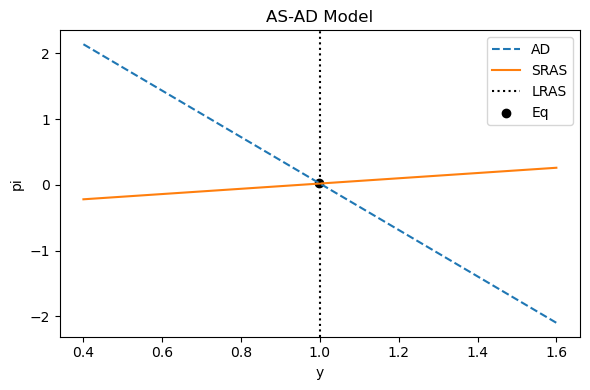

In [184]:

def plot_grid(pi_e=0.02, v=0.0, s=0.0, p=par, title="AS–AD (grid)"):
    y_star, pi_star, y, pi_ad, pi_sras = solve_grid(pi_e, v, s, p) # we call the solve function to get equilibrium and curves
    print(f"Equilibrium: y*={y_star:.4f}, pi*={pi_star:.4f}") # this prints the equilibrium values
    plt.figure(figsize=(6,4)) # the remaining part is plotting
    plt.plot(y, pi_ad,  "--", label="AD")
    plt.plot(y, pi_sras, "-",  label="SRAS")
    plt.axvline(p["ybar"], color="k", ls=":", label="LRAS")
    plt.scatter([y_star],[pi_star], c="k", label="Eq")
    plt.xlabel("y"); plt.ylabel("pi"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

## we call teh function: 
# Example
plot_grid(pi_e=0.02, v=0.0, s=0.00, title="AS-AD Model")


### 1.2. <a id='toc1_2_'></a>[Policy exercises:](#toc0_)

We consider four scenarios:

**AD (level): demand shock**
- $v \uparrow$  $\Rightarrow$ AD shifts **right** (higher $y,\pi$).

**AD (slope): Taylor rule parameters**
- $a_1 \uparrow$ (stronger response to inflation gap) $\Rightarrow$ AD becomes **more downward-sloping** (inflation moves less).
- $a_2 \uparrow$ (more response to output gap) $\Rightarrow$ AD becomes **flatter** (output stabilizes more).

**SRAS (level): supply / expectations**
- $s \uparrow$ $\Rightarrow$ SRAS shifts **up** (stagflation: $\pi \uparrow$, $y \downarrow$).
- Higher short-run expectations $\,\pi^e \uparrow\,$ $\Rightarrow$ SRAS **up** (we keep $\pi^e=\pi^*$ in baseline).

**LRAS**
- $\,\bar y\,$ moves the vertical LRAS; we hold $\bar y$ fixed.


1) **Demand shock:** $v=+0.3$  AD **right**.  
2) **Supply shock:** $s=+0.1$ (10pp) $\Rightarrow$ SRAS **up**.  
3) **Stronger inflation focus:** $a_1: 1.5 \rightarrow 2.0$ $\Rightarrow$ AD **more downward-sloping**.  
4) **More output-gap response:** $a_2: 0.10 \rightarrow 0.30$ $\Rightarrow$ AD **flatter**.

*In each case we draw AD and SRAS, mark the new equilibrium $(y^*,\pi^*)$, and compare to the baseline (no shocks, $\pi^e=\pi^*$).*


In [160]:

def plot_policy_scenario(par, scenario, y_pad=0.6):
    """
    Plot baseline vs ONE scenario (uses solve_grid for both curves + equilibrium).
    Legend: SRAS/AD (baseline), LRAS, Eq (baseline), SRAS/AD (scenario), Eq (scenario).
    """
    base = par.copy()

    # ----- Baseline (no shocks, pi_e = pi_star) --------------------------------
    
    base_shocks = {"v": 0.0, "s": 0.0, "pi_e": base["pi_star"]}
    # Here we call solve_grid from above
    y_b, pi_b, ygrid_b, pi_ad_b, pi_sras_b = solve_grid(
        pi_e=base_shocks["pi_e"], v=base_shocks["v"], s=base_shocks["s"],
        p=base, pad=y_pad, n=400
    )

    # ----- Scenario: split shocks vs parameter changes -------------------------
    name = scenario.get("name", "scenario") # we first read the scenario name (for the plot title)
    changes = scenario.get("d", {}) # then the dict of changes, that describes what we want to change  (supply or demand shocks, or parameters)
    shocks = {k: changes[k] for k in ["v", "s", "pi_e"] if k in changes} # we separate shocks from parameter changes (we have here a demand shock, a supply shock, and expected inflation)   
    params = {k: changes[k] for k in changes.keys() if k not in shocks} # the rest are parameter 
    shocks.setdefault("v", 0.0) # if the scenario does not specify a demand shock, we set it to zero    
    shocks.setdefault("s", 0.0) # same for supply shock
    shocks.setdefault("pi_e", base["pi_star"]) # if not specified, expected inflation is at target  

    # Here we build the parameter dictionary for this scenario
    # note that base holds the baseline parameters
    P = base.copy() # this creates a copy of the baseline parameters
    P.update(params) # overwrite with any parameter changes from the scenario

    # Now we call solve_grid for the scenario
    y_s, pi_s, ygrid_s, pi_ad_s, pi_sras_s = solve_grid(
        pi_e=shocks["pi_e"], v=shocks["v"], s=shocks["s"],
        p=P, pad=y_pad, n=400
    )

    # ----- Plot (one figure) ---------------------------------------------------
    fig, ax = plt.subplots(figsize=(6.5, 4.5))

    # Baseline curves + equilibrium (gray)
    ax.plot(ygrid_b, pi_sras_b, color="#666666", lw=1.6, label="SRAS (baseline)")
    ax.plot(ygrid_b, pi_ad_b,   color="#666666", lw=1.6, ls="--", label="AD (baseline)")
    ax.axvline(base["ybar"], color="k", ls=":", lw=1.2, label="LRAS")
    ax.scatter([y_b], [pi_b], color="black", s=28, zorder=5, label="Eq (baseline)")

    # Scenario curves + equilibrium (blue)
    ax.plot(ygrid_s, pi_sras_s, color="#1f77b4", lw=2.2, label="SRAS (scenario)")
    ax.plot(ygrid_s, pi_ad_s,   color="#1f77b4", lw=2.2, ls="--", label="AD (scenario)")
    ax.scatter([y_s], [pi_s], color="#1f77b4", edgecolor="k", s=42, zorder=6, label="Eq (scenario)")

    ax.set_xlabel("y"); ax.set_ylabel("pi")
    ax.set_title(f"AS–AD: {name}")
    ax.legend(loc="best", frameon=True)
    plt.tight_layout(); plt.show()


Now, we call the different scenarios:

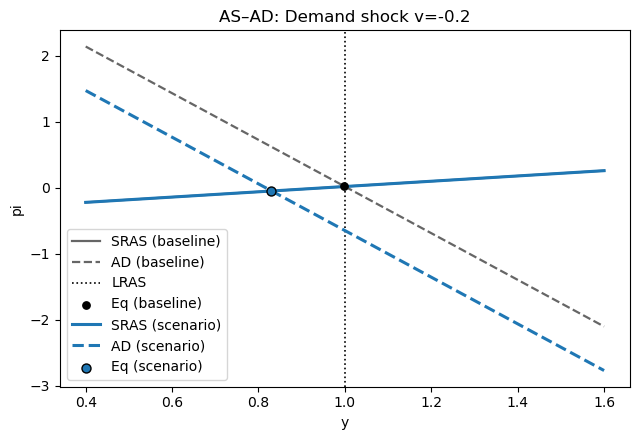

In [187]:
# Demand shock
plot_policy_scenario(par, {"name": "Demand shock v=-0.2", "d": {"v": -0.2}}, y_pad=0.6)

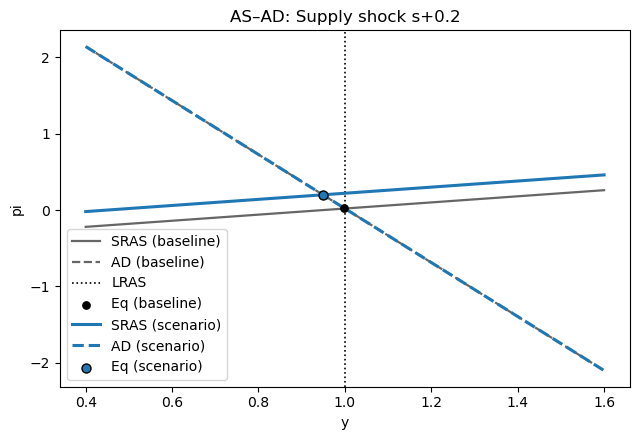

In [189]:
plot_policy_scenario(par, {"name": "Supply shock s+0.2", "d": {"s": 0.2}}, y_pad=0.6)

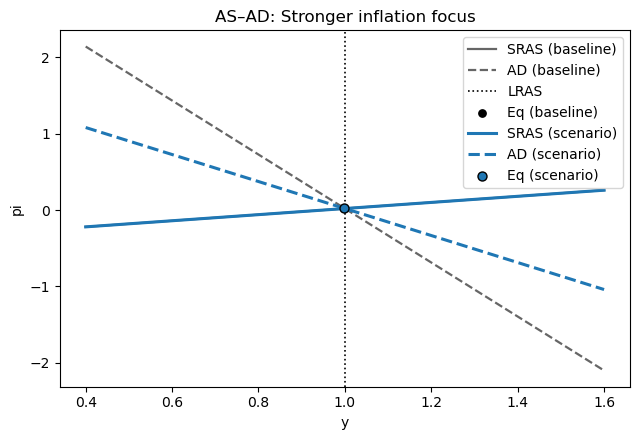

In [190]:
# Stronger focus on inflation (higher a1)
plot_policy_scenario(par, {"name": "Stronger inflation focus", "d": {"a1": 2.0}}, y_pad=0.6)


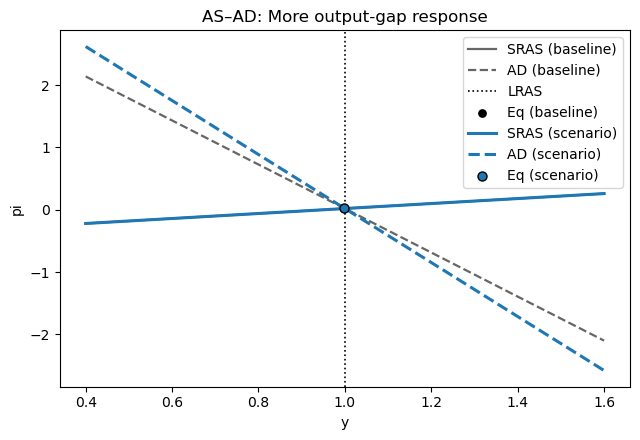

In [192]:
# More response to output gap (higher a2)
plot_policy_scenario(par, {"name": "More output-gap response", "d": {"a2": 0.50}}, y_pad=0.6)

## 2. <a id='toc2_'></a>[Dynamics](#toc0_)

Now we will assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
v_{t} &= \delta v_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a demand shock, and $c_t$ is a supply shock 

The autoregressive parameters are given by

In [165]:
par['delta'] = 0.80
par['omega'] = 0.15

Assume that $x_t$ and $c_t$ are  normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

with standard deviations

In [166]:
par['sigma_x'] = 1.0
par['sigma_c'] = 0.2

We will now construct impulse responses to answer the following question: *Starting from the long-run equilibrium, how does the economy evolve in response to a one-time, one standard-deviation demand shock?* 

The starting point of the economy is $y_{-1} = \pi_{-1} = s_{-1} = 0$. 
We look at a one-time shock: in period $t=0$ there is a shock to $x$ of size $\sigma_x$, and for all later periods there are no more shocks to $x$ or $c$.

*Step 1*
Define two functions that we will reuse later:
1. allocate memories and draw random shocks given parameters and the number of time periods we want to simulate
2. simulate the economy given the shock sequences from 1. 

*Step 2*
Run the simulations.

*Step 3*
Illustrate the results in two ways: 
1. in $(y,\pi)$-space, and 
2. plotting $y$ and $\pi$ as a function of periods since the shock. 

We modify our original function solve_grid so that the model finds the equilibrium $(y^,\pi^)$ much more accurately in every period of the transition. That avoids small numerical errors that would otherwise accumulate over time.

In [168]:
def solve_grid_fine(pi_e=0.02, v=0.0, s=0.0, p=par, pad=0.6, n=800):
    """
    Return (y*, pi*, ygrid, pi_ad, pi_sras) using linear interpolation
    to solve pi_ad(y) - pi_sras(y) = 0 on the grid.
    """
    y = np.linspace(p["ybar"] - pad, p["ybar"] + pad, n)
    pi_ad   = ad_curve(y, p, v)
    pi_sras = sras_curve(y, p, pi_e, s)
    diff = pi_ad - pi_sras # here we compute the difference between the two curves, in equilibrium this should be zero

    # Try to find a sign change and interpolate
    idx = np.where(diff[:-1] * diff[1:] <= 0)[0] # indices where sign change occurs
    if len(idx) > 0: # if we found at least one sign change
        i = idx[0] # take the first one
        y0, y1 = y[i], y[i+1] # we have two points surrounding the root
        d0, d1 = diff[i], diff[i+1] # corresponding differences
        w = d0 / (d0 - d1)          # The code finds two points where AD and SRAS are on different sides,
        # draws a straight line between them, and uses w to walk from the left point toward the right until that straight line hits zero.
        #  That position is our approximate equilibrium output, and then we read off inflation there

        y_star = y0 + w*(y1 - y0) # evaluate output at root
        # Evaluate pi using one curve (they're equal at the root)
        pi_star = pi_ad[i] + w*(pi_ad[i+1] - pi_ad[i])

    return float(y_star), float(pi_star), y, pi_ad, pi_sras


Remember the random number generator from Lecture 8, we use that here to get an AR(1) shock generator:

In [169]:

# ---- 1) Simple AR(1) shock generator ----------------------------------------
def ar1_series(T, rho, sigma, seed=None, shock0=0.0):
    rng = np.random.default_rng(seed)
    e   = rng.normal(0.0, sigma, size=T)
    x   = np.empty(T); x[0] = shock0
    for t in range(1, T):
        x[t] = rho*x[t-1] + e[t]
    return x


Now, we can set up a function that allows us to dynamically simulate the AS-AD model for different types of shocks. The function simulates how output and inflation move over time in the AS AD model when the economy is hit by shocks.

In [170]:
def simulate_asad(T=80, pars=None, n=400, seed=42,
                  mode="stochastic",      # "stochastic" or "impulse"
                  which="demand",         # "demand" or "supply" if impulse
                  size=0.02,              # impulse size
                  pad=0.6):               # grid half-width for solve_grid
    """
    Dynamics (grid-based each period):
      v_t = delta*v_{t-1} + x_t
      s_t = omega*s_{t-1} + c_t
      pi_e[t] = pi[t-1]
      (y[t], pi[t]) from solve_grid(pi_e, v, s, p, pad, n)
    """
    p = pars if pars is not None else par
    T = int(T)

    # --- shocks
    if mode == "stochastic": # case 1 -- stochastic shocks
        v = ar1_series(T, p["delta"], p["sigma_x"], seed=seed,   shock0=0.0)  # build the demand shock series
        s = ar1_series(T, p["omega"], p["sigma_c"], seed=seed+1, shock0=0.0)  # supply shock series
    elif mode == "impulse": # case 2 -- impulse responses
        v = np.zeros(T); s = np.zeros(T)
        if which == "demand":
            v[0] = size # set initial demand shock
        elif which == "supply":
            s[0] = size # same for supply shock
        else:
            raise ValueError("which must be 'demand' or 'supply'")
        for t in range(1, T):
            v[t] = p["delta"]*v[t-1] # shock fade out over time based on the AR(1) structure
            s[t] = p["omega"]*s[t-1]
    else:
        raise ValueError("mode must be 'stochastic' or 'impulse'")

    # --- prepare containers for the results
    y    = np.empty(T) 
    pi   = np.empty(T)
    pi_e = np.empty(T)

    # start at steady state
    pi_tm1 = p["pi_star"]
    
    # dynamic loop over time
    for t in range(T):
        pi_e[t] = pi_tm1                              # adaptive expectations
        y[t], pi[t], *_ = solve_grid_fine(                 # solve the AS AD model on the fine grid for THIS period
            pi_e=pi_e[t], v=v[t], s=s[t], p=p, pad=pad, n=n
        )
        pi_tm1 = pi[t] # update last period's inflation

    return {"y": y, "pi": pi, "v": v, "s": s, "pi_e": pi_e, "par": p}


Here is a small function that helps us plotting the results

In [171]:
# ----  Plot for Inflation; Output and Shocks -------------
def plot_paths(res, title_suffix=""):
    p = res["par"]
    # Inflation
    plt.figure(figsize=(6.4,3.4))
    plt.plot(res["pi"], lw=2)
    plt.axhline(p["pi_star"], ls="--", c="k", lw=1)
    plt.title(f"Inflation path {title_suffix}")
    plt.xlabel("t"); plt.ylabel("pi")
    plt.tight_layout(); plt.show()

    # Output
    plt.figure(figsize=(6.4,3.4))
    plt.plot(res["y"], lw=2)
    plt.axhline(p["ybar"], ls="--", c="k", lw=1)
    plt.title(f"Output path {title_suffix}")
    plt.xlabel("t"); plt.ylabel("y")
    plt.tight_layout(); plt.show()

    # Shocks
    plt.figure(figsize=(6.4,3.4))
    plt.plot(res["v"], label="v (demand)")
    plt.plot(res["s"], label="s (supply)")
    plt.title(f"Shocks {title_suffix}")
    plt.xlabel("t"); plt.legend()
    plt.tight_layout(); plt.show()


### 2.1. <a id='toc2_1_'></a>[Demand Schock](#toc0_)

Now, we only need to call the simulate_asad function and plot the results for different scenarios.

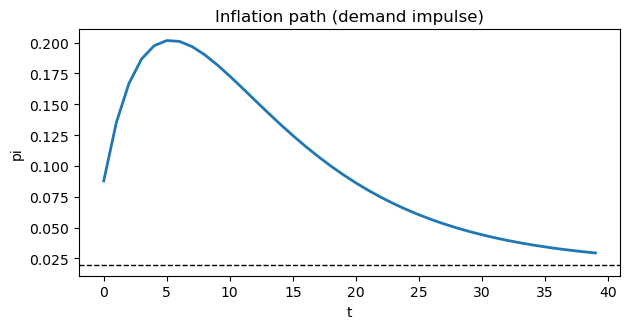

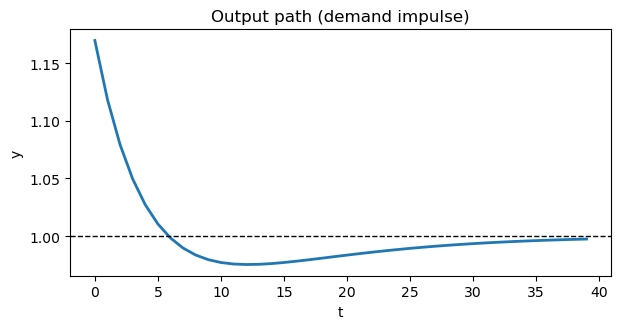

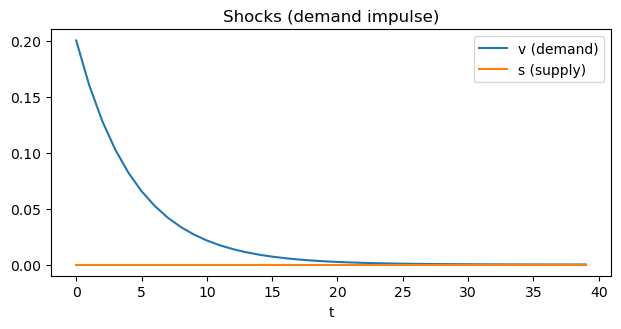

In [172]:
# A) Demand Shock
res_dem = simulate_asad(T=40, mode="impulse", which="demand", size=0.2, pars=par)
plot_paths(res_dem, "(demand impulse)")


### 2.2. <a id='toc2_2_'></a>[Supply Shocks](#toc0_)

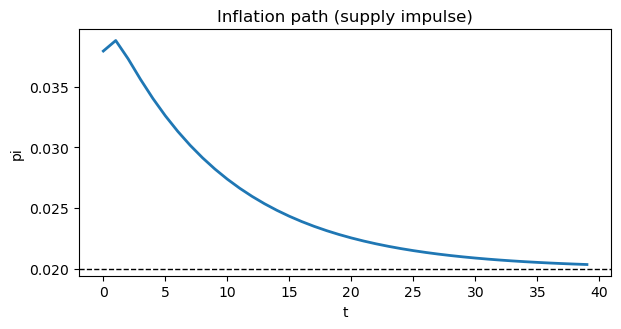

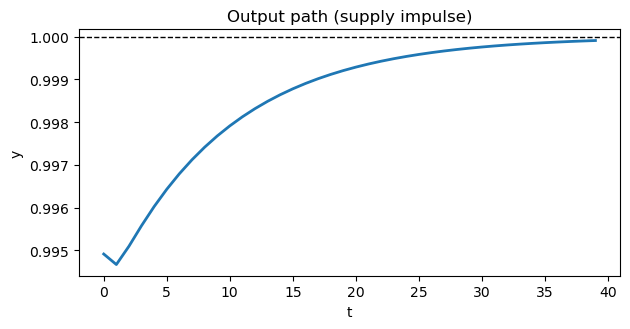

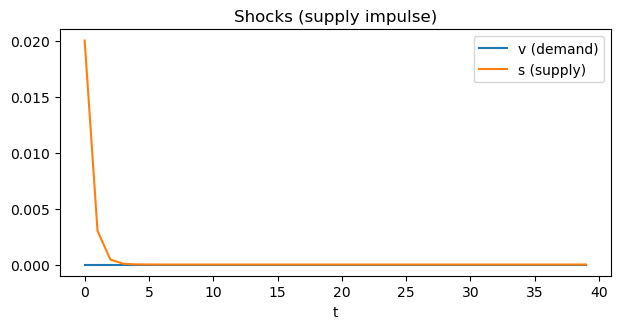

In [173]:

res_sup = simulate_asad(T=40, mode="impulse", which="supply", size=0.02, pars=par)
plot_paths(res_sup, "(supply impulse)")


### 2.3. <a id='toc2_3_'></a>[Stronger Focus on Inflation](#toc0_)

We change the value of a1 to lower inflation volatility and compare the differences in a stochastic simulation.

In [174]:
par_stronger = {**par, "a1": 2.0}
res_stoch_base = simulate_asad(T=200, mode="stochastic", seed=1, pars=par)
res_stoch_a1   = simulate_asad(T=200, mode="stochastic", seed=1, pars=par_stronger)


Let's define a small function that helps us summarize the std of each version:

In [175]:
def summarize(name, res):
    y, pi = res["y"], res["pi"]
    print(f"{name:20s}  std(y)={np.std(y):.4f}  std(pi)={np.std(pi):.4f}")

summarize("Baseline", res_stoch_base)
summarize("Stronger a1", res_stoch_a1)


Baseline              std(y)=0.0099  std(pi)=0.0174
Stronger a1           std(y)=0.0092  std(pi)=0.0125


Finally, we can visualize the simulation results:

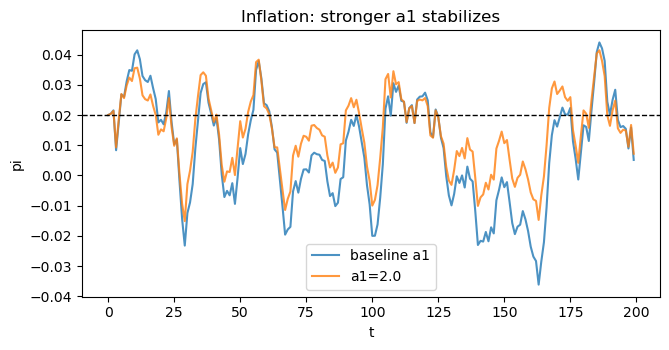

In [176]:
# Plot inflation side-by-side to see stabilization
plt.figure(figsize=(6.8,3.6))
plt.plot(res_stoch_base["pi"], alpha=0.8, label="baseline a1")
plt.plot(res_stoch_a1["pi"],   alpha=0.8, label="a1=2.0")
plt.axhline(par["pi_star"], ls="--", c="k", lw=1)
plt.title("Inflation: stronger a1 stabilizes")
plt.xlabel("t"); plt.ylabel("pi"); plt.legend(); plt.tight_layout(); plt.show()


## 3. <a id='toc3_'></a>[Extensions: Loss & Grid Search](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Minimize Loss Function](#toc0_)

**Goal.** Find the Taylor‐rule coefficients $(a_1,a_2)$ that minimize a simple quadratic loss:
$
L=\sum_{t=0}^{T-1}\Big[(\pi_t-\pi^*)^2+\lambda\,(y_t-\bar y)^2\Big].
$

**Steps:**
1. **Fix one set of shocks** $(v_t,s_t)$ by simulating AR(1) processes once.  
2. **Dynamics:** use adaptive expectations $\pi_t^e=\pi_{t-1}$.  
   Each period, get $(y_t,\pi_t)$ from the **grid-based** equilibrium `solve_grid(pi_e,v,s, p)`.
3. **Loop over a coarse grid** of $(a_1,a_2)$. For each pair, simulate paths and compute $L$.
4. **Plot a heatmap** of the loss over the grid and **mark the best** $(a_1,a_2)$.


In [177]:
import numpy as np, matplotlib.pyplot as plt


# creating demand and supply shocks for T periods
def make_shocks(T, p, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.normal(0, p["sigma_x"], T); c = rng.normal(0, p["sigma_c"], T) # innovations follow a normal distribution with given std
    v = np.zeros(T); s = np.zeros(T) # initialize shocks
    for t in range(1,T): v[t]=p["delta"]*v[t-1]+x[t]; s[t]=p["omega"]*s[t-1]+c[t] # build AR(1) shocks
    return v, s

# simulate with given rule parameters a1, a2 over shocks v,s and parameters p; uses solve_grid from above
def simulate_with_rule_grid(a1, a2, v, s, p, pad=0.6, n=400):
    P = {**p, "a1": float(a1), "a2": float(a2)}
    T=len(v); y=np.empty(T); pi=np.empty(T); pi_prev=P["pi_star"]
    for t in range(T):
        y[t], pi[t], *_ = solve_grid(pi_e=pi_prev, v=v[t], s=s[t], p=P, pad=pad, n=n)
        pi_prev = pi[t]
    return y, pi

# loss function: quadratic loss on inflation and output gap deviations (squared deviations of inflation from target and output from steady state output)
# lam is the weight on output gap deviations
def loss_quad(y, pi, p, lam=0.5):
    return float(np.sum((pi-p["pi_star"])**2 + lam*(y-p["ybar"])**2))


Let's build a function for the grid search:

In [178]:
def tiny_grid_search(p, a1_vals, a2_vals, T=120, lam=0.5, seed=1):
    v, s = make_shocks(T, p, seed)              # create shocks
    L = np.empty((len(a1_vals), len(a2_vals)))  # initialize loss matrix

    for i, a1 in enumerate(a1_vals):            # iterate over a1 values
        for j, a2 in enumerate(a2_vals):        # iterate over a2 values
            y, pi = simulate_with_rule_grid(a1, a2, v, s, p)   # simulate with given rule
            L[i, j] = loss_quad(y, pi, p, lam)                 # compute loss

    # indices of minimum loss
    i0, j0 = np.unravel_index(np.argmin(L), L.shape)

    # best parameters
    a1_star = float(a1_vals[i0])
    a2_star = float(a2_vals[j0])
    loss_star = float(L[i0, j0])

    # pack in dict for convenience
    best = {"a1": a1_star, "a2": a2_star, "loss": loss_star}

    # print nicely
    print(f"Best rule: a1 = {best['a1']:.2f}, a2 = {best['a2']:.2f}, loss = {best['loss']:.3g}")

    # heatmap plot of the loss function
    plt.figure(figsize=(6, 4))
    plt.imshow(
        L.T,
        origin="lower",
        aspect="auto",
        extent=[a1_vals[0], a1_vals[-1], a2_vals[0], a2_vals[-1]],
    )
    plt.colorbar(label="loss")
    plt.scatter(best["a1"], best["a2"], c="w", edgecolor="k", s=80)

    plt.xlabel("a1 (inflation response)")
    plt.ylabel("a2 (output-gap response)")
    plt.title(f"Best: a1={best['a1']:.2f}, a2={best['a2']:.2f}, loss={best['loss']:.3g}")
    plt.tight_layout()
    plt.show()

    return L, best


Here we apply the grid search, plot the results in a heatmap and print the best parameters and the corresponding loss.

Best rule: a1 = 2.20, a2 = 0.25, loss = 0.0657


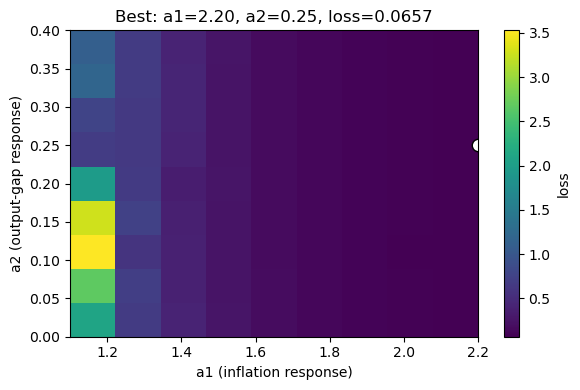

{'a1': 2.2, 'a2': 0.25, 'loss': 0.06567109196075957}


In [179]:

par_dyn = {"ybar":1.0,"pi_star":0.02,"b":0.6,"a1":1.5,"a2":0.10,"gamma":0.4,
           "delta":0.80,"omega":0.15,"sigma_x":0.01,"sigma_c":0.005}
a1_vals = np.linspace(1.1, 2.2, 9)   # > 1
a2_vals = np.linspace(0.00, 0.40, 9)
L, best = tiny_grid_search(par_dyn, a1_vals, a2_vals, T=120, lam=0.5, seed=7)
print(best)


### 3.2. <a id='toc3_2_'></a>[Policy Frontier](#toc0_)

How do changes in a1 affect the standard deviations of inflation vs. output?

What we do next:
- We fix the output-gap response a2.
- We vary the inflaiton response a1 over a range of values.
- We simulate the economy under the same shocks and measure, this allows us to compute the std(y) and std(pi) - i.e. how volatile output and inflation is.
- Finally, we plot these points in a std(y)-std(pi) dimension.

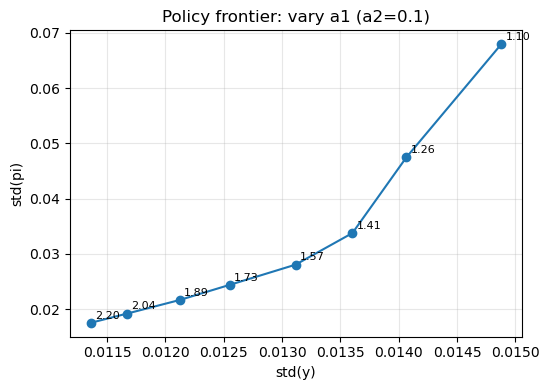

In [180]:
import numpy as np, matplotlib.pyplot as plt

def policy_frontier_a1(p, a1_vals, a2_fixed=0.10, T=200, seed=1):
    v,s = make_shocks(T, p, seed) # create shocks
    pts = []
    for a1 in a1_vals: # loop over a1 values
        y,pi = simulate_with_rule_grid(a1, a2_fixed, v, s, p) # simulate with given rule
        pts.append((np.std(y), np.std(pi))) # store std deviations of output and inflation   
    pts = np.array(pts) # convert to array for easier plotting
    # make the plot
    plt.figure(figsize=(5.6,4))
    plt.plot(pts[:,0], pts[:,1], marker="o")
    for (x,yv),a1 in zip(pts, a1_vals):
        plt.annotate(f"{a1:.2f}", (x,yv), textcoords="offset points", xytext=(3,3), fontsize=8)
    plt.xlabel("std(y)"); plt.ylabel("std(pi)")
    plt.title(f"Policy frontier: vary a1 (a2={a2_fixed})")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
    return pts

#  Application
a1_line = np.linspace(1.1, 2.2, 8)
_ = policy_frontier_a1(par_dyn, a1_line, a2_fixed=0.10, T=200, seed=3)


## 4. <a id='toc4_'></a>[Take Aways:](#toc0_)

- **Static AS–AD setup.** We code the static mode and solve the $AD-SRAS$ equilibrium and plot the curves and $(y^*,\pi^*)$.

- **Shock responses (comparative statics).** We shift curves and recompute the equilibrium: demand shock $v\uparrow$ moves $AD$ right; supply shock $s\uparrow$ moves $SRAS$ up. We visualize how $(y^*,\pi^*)$ changes in each case.

- **Demand vs. supply contrasts.** $v$ affects the level of $AD$ (and via $a_1,a_2$ its slope), typically $y\uparrow,\ \pi\uparrow$; $s$ raises costs, giving stagflation patterns ($y\downarrow,\ \pi\uparrow$). Plots make the different mechanisms transparent.

- **Policy extensions.** We define a quadratic loss and do a coarse grid search over $(a_1,a_2)$ using the same shocks, then visualize $L$ as a heatmap and mark the best rule.
